In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import truncnorm

C:\Users\wxrde\AppData\Local\Temp\ipykernel_42884\3349093964.py:24: RuntimeWarning: invalid value encountered in scalar divide
  dSdt = r * (1 - N/N_max) * E_S * S - (beta * S * R) / N + lambda_ * (1 - rho) * nu
C:\Users\wxrde\AppData\Local\Temp\ipykernel_42884\3349093964.py:25: RuntimeWarning: invalid value encountered in scalar divide
  dRdt = r * (1 - alpha) * (1 - N/N_max) * E_R * R + (beta * S * R)/N + lambda_ * rho * nu


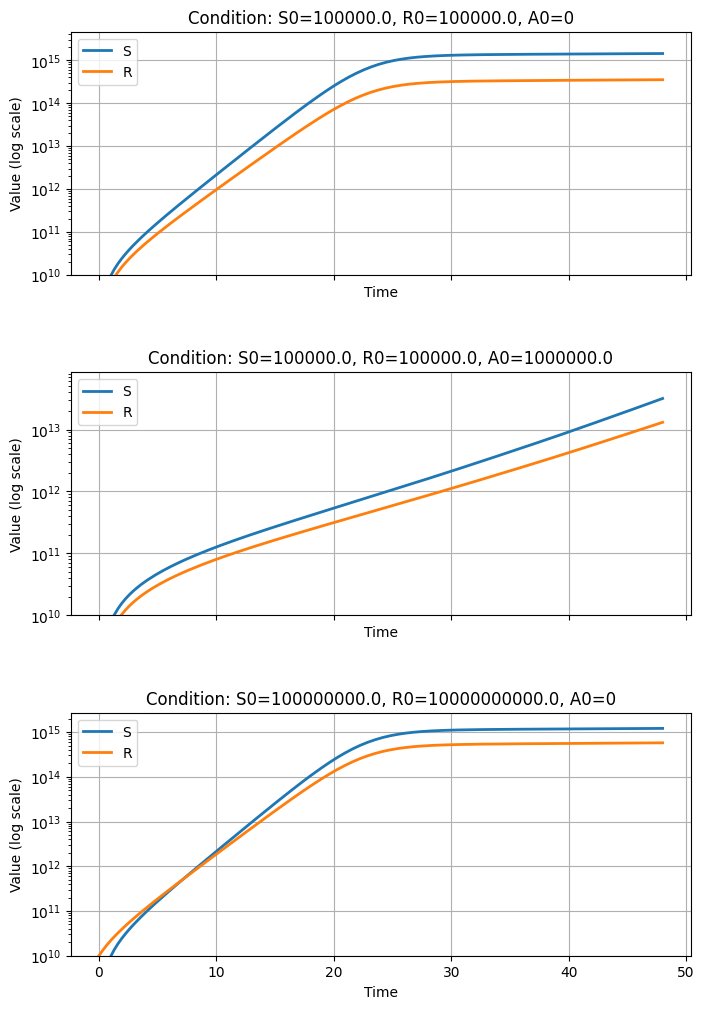

In [18]:
# model class
class GrowthModel:
    def __init__(self, p, vol_concent):
        self.p = p  # parameters
        self.vol_concent = vol_concent

    def __call__(self, t, y):
        y = np.maximum(y, 0) 
        S, R = y # diff eq functions
        
        # unpack parameters
        r, beta, lambda_, nu, rho, alpha, theta, E_max, H, MIC_S, MIC_R, mu, gamma = self.p
        V_i, A_i = self.vol_concent

        # model functions
        N = S + R # total bacteria population
        V = V_i + lambda_*t # slurry tank volume
        A = (A_i - (theta / gamma)) * np.exp(-1.0 * gamma * t) + (theta / gamma) # antibiotic concentration
        N_max =  mu * V # max carrying capacity
        E_S = 1 - (E_max * (A / V)**H ) / (MIC_S**H + (A / V)**H) # antibiotic effect on sensitive
        E_R = 1 - (E_max * (A / V)**H) / (MIC_S**H + (A / V)**H) # antibiotic effect on resistant

        # differential equations
        dSdt = r * (1 - N/N_max) * E_S * S - (beta * S * R) / N + lambda_ * (1 - rho) * nu
        dRdt = r * (1 - alpha) * (1 - N/N_max) * E_R * R + (beta * S * R)/N + lambda_ * rho * nu

        return [dSdt, dRdt]


# simulation class
class Simulation:
    def __init__(self, p, S0, R0, V0, A0):
        self.p = p  # parameters
        self.S0 = S0  # inital sentitive pop
        self.R0 = R0  # initial resistant pop
        self.V0 = V0  # initial volume in slurry tank
        self.A0 = A0  # initial antibiotic concentration

        self.y0 = np.array([S0, R0])  # initial bacteria state
        self.vol_concent0 = np.array([V0, A0]) # initial env state

    def run(self, t_span=np.linspace(0, 24), num_time_points=500):
        t_eval = np.linspace(t_span[0], t_span[1], num_time_points)
        model = GrowthModel(self.p, self.vol_concent0)
        sol = solve_ivp(model, t_span, self.y0, t_eval=t_eval)
        return sol.t, sol.y
    
# plotter class
class Plotter:
    def plot(self, t, results, conditions, variables=['S', 'R']):
        fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
        plt.subplots_adjust(hspace=0.4)

        # loop through the results for each condition and plot
        for i, (result, (S0, R0, A0)) in enumerate(zip(results, conditions)):
            ax = axs[i]
            ax.set_title(f'Condition: S0={S0}, R0={R0}, A0={A0}')
            for j, variable in enumerate(variables):
                ax.semilogy(t, result[j], label=variable, lw=2)

            ax.set_xlabel('Time')
            ax.set_ylabel('Value (log scale)')
            ax.set_ylim(bottom=1e10)
            ax.grid(True)
            ax.legend()

        plt.show()



# parameters
p = [0.5, 0.001, 613, 2e7, 0.4, 0.1, 3422, 2, 2, 8, 2000, 1e10, 0.0029]
t_span = (0, 48)
num_time_points = 150

# initial conditions
conditions = [(1e5, 1e5, 0), (1e5, 1e5, 1e6), (1e8, 1e10, 0)]
V0 = 150000

# run simulation
all_results = []
for S0, R0, A0 in conditions:
    sim = Simulation(p, S0, R0, V0, A0)
    t, results = sim.run(t_span=t_span, num_time_points=num_time_points)
    all_results.append(results)

# plot results
plotter = Plotter()
plotter.plot(t, all_results, conditions)